# ALAD - Toy examples

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection"
Credits : https://github.com/ChunyuanLI/ALICE

### Imports

In [142]:
%matplotlib inline

import os
import pdb

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from utils.data_gmm import GMM_distribution, sample_GMM, plot_GMM
from utils.data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

slim = tf.contrib.slim
ds = tf.contrib.distributions
graph_replace = tf.contrib.graph_editor.graph_replace

### Parameters

In [144]:
DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100

In [145]:
""" parameters """
n_epoch = 300
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [146]:
""" Create directory for results """
result_dir = 'results/alad_toy/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [147]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],
                                          [-2, -2],
                                          [2, -2],
                                          [-2, 2],
                                           [0, 0]])
    
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]

    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,
                                                   variances=variances_x,
                                                   priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x

You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset

In [148]:
dataset_x = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_train.png'


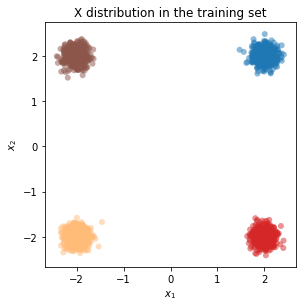

In [149]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

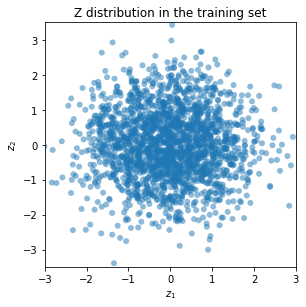

In [150]:
# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()

## Network

In [151]:
""" Networks """

def generative_network(z, input_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("generative", reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, input_dim, activation_fn=None)
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("inference", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None)      
    return z

def data_network_xz(x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
    """Approximate x log data density."""
    h = tf.concat([x,z], 1)
    with tf.variable_scope('discriminator', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_xx(x,x_hat, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([x,x_hat], 1)
    with tf.variable_scope('discriminator_xx', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_zz(z, z_prime, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([z, z_prime], 1)
    with tf.variable_scope('discriminator_zz', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

In [152]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_dim))
z = tf.placeholder(tf.float32, shape=(None, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
q_z = inference_network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

decoder_logit = data_network_xz(p_x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit = graph_replace(decoder_logit, {p_x: x, z:q_z})

decoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(decoder_logit), logits=decoder_logit)
encoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(encoder_logit), logits=encoder_logit)

dis_loss_xz = tf.reduce_mean(encoder_loss) + tf.reduce_mean(decoder_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)

x_logit_real = data_network_xx(x, x)
x_logit_fake = data_network_xx(x, rec_x, reuse=True)
z_logit_real = data_network_zz(z, z)
z_logit_fake = data_network_zz(z, rec_z,  reuse=True)

x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))

z_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.ones_like(z_logit_real))
z_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.zeros_like(z_logit_fake))

x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))


dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

cost_x = tf.reduce_mean(x_sigmoid_real2 + x_sigmoid_fake2) # + tf.reduce_mean(tf.pow(x_feature_real - x_feature_fake, 2))
cost_z = tf.reduce_mean(z_sigmoid_real2 + z_sigmoid_fake2) # + tf.reduce_mean(tf.pow(z_feature_real - z_feature_fake, 2))


decoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(decoder_logit), logits=decoder_logit)
encoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(encoder_logit), logits=encoder_logit)

gen_loss_xz = tf.reduce_mean(decoder_loss2)  + tf.reduce_mean(encoder_loss2)

gen_loss = gen_loss_xz + cost_x  + cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx)

mahalanobis_dis_z = tf.norm(q_z, ord=2, axis=1, keep_dims=False, name='z_scores')

## Training

In [112]:
""" training """
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)

    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

  0%|          | 1/300 [00:02<12:51,  2.58s/it]

epoch 0 iter 2: discloss 4.335891 genloss 3.421293 adv_x 1.172381 recons_x 1.135755 


  1%|          | 2/300 [00:04<11:10,  2.25s/it]

epoch 1 iter 2: discloss 5.703974 genloss 4.153392 adv_x 1.318510 recons_x 1.586031 


  1%|          | 3/300 [00:05<10:12,  2.06s/it]

epoch 2 iter 2: discloss 5.123941 genloss 4.300347 adv_x 1.324444 recons_x 1.636631 


  1%|▏         | 4/300 [00:07<09:24,  1.91s/it]

epoch 3 iter 2: discloss 4.242617 genloss 4.444621 adv_x 1.412797 recons_x 1.682189 


  2%|▏         | 5/300 [00:08<08:47,  1.79s/it]

epoch 4 iter 2: discloss 4.347875 genloss 4.314517 adv_x 1.253841 recons_x 1.680524 


  2%|▏         | 6/300 [00:10<08:09,  1.67s/it]

epoch 5 iter 2: discloss 6.285276 genloss 4.554699 adv_x 1.538148 recons_x 1.598951 


  2%|▏         | 7/300 [00:11<07:41,  1.58s/it]

epoch 6 iter 2: discloss 4.448169 genloss 3.946428 adv_x 1.307832 recons_x 1.172231 


  3%|▎         | 8/300 [00:12<07:19,  1.51s/it]

epoch 7 iter 2: discloss 4.338625 genloss 4.123456 adv_x 1.048390 recons_x 1.635413 


  3%|▎         | 9/300 [00:14<07:03,  1.45s/it]

epoch 8 iter 2: discloss 4.750826 genloss 4.147830 adv_x 1.091991 recons_x 1.574723 


  3%|▎         | 10/300 [00:15<07:17,  1.51s/it]

epoch 9 iter 2: discloss 4.331019 genloss 4.057428 adv_x 1.187325 recons_x 1.464499 


  4%|▎         | 11/300 [00:17<07:32,  1.57s/it]

epoch 10 iter 2: discloss 4.822272 genloss 4.114429 adv_x 1.072211 recons_x 1.617397 


  4%|▍         | 12/300 [00:19<07:39,  1.60s/it]

epoch 11 iter 2: discloss 4.535330 genloss 4.188826 adv_x 1.185474 recons_x 1.580822 


  4%|▍         | 13/300 [00:20<07:39,  1.60s/it]

epoch 12 iter 2: discloss 4.089311 genloss 4.263366 adv_x 1.439592 recons_x 1.432505 


  5%|▍         | 14/300 [00:22<07:30,  1.57s/it]

epoch 13 iter 2: discloss 4.447261 genloss 4.020738 adv_x 1.176610 recons_x 1.445300 


  5%|▌         | 15/300 [00:23<07:24,  1.56s/it]

epoch 14 iter 2: discloss 4.305418 genloss 4.225264 adv_x 1.401178 recons_x 1.432410 


  5%|▌         | 16/300 [00:25<07:29,  1.58s/it]

epoch 15 iter 2: discloss 4.181596 genloss 4.161709 adv_x 1.366287 recons_x 1.404364 


  6%|▌         | 17/300 [00:27<07:26,  1.58s/it]

epoch 16 iter 2: discloss 4.210628 genloss 4.154803 adv_x 1.371546 recons_x 1.391658 


  6%|▌         | 18/300 [00:28<07:20,  1.56s/it]

epoch 17 iter 2: discloss 4.161227 genloss 4.205899 adv_x 1.421056 recons_x 1.395178 


  6%|▋         | 19/300 [00:30<07:21,  1.57s/it]

epoch 18 iter 2: discloss 4.141623 genloss 4.198981 adv_x 1.415477 recons_x 1.391798 


  7%|▋         | 20/300 [00:31<07:19,  1.57s/it]

epoch 19 iter 2: discloss 4.195093 genloss 4.141194 adv_x 1.358261 recons_x 1.391097 


  7%|▋         | 21/300 [00:33<07:18,  1.57s/it]

epoch 20 iter 2: discloss 4.210154 genloss 4.154336 adv_x 1.365903 recons_x 1.396682 


  7%|▋         | 22/300 [00:34<07:18,  1.58s/it]

epoch 21 iter 2: discloss 4.143094 genloss 4.179940 adv_x 1.390768 recons_x 1.395331 


  8%|▊         | 23/300 [00:36<07:14,  1.57s/it]

epoch 22 iter 2: discloss 4.162975 genloss 4.158836 adv_x 1.366836 recons_x 1.391865 


  8%|▊         | 24/300 [00:38<07:53,  1.72s/it]

epoch 23 iter 2: discloss 4.160296 genloss 4.166523 adv_x 1.372782 recons_x 1.392154 


  8%|▊         | 25/300 [00:40<08:46,  1.92s/it]

epoch 24 iter 2: discloss 4.149273 genloss 4.178286 adv_x 1.384452 recons_x 1.389684 


  9%|▊         | 26/300 [00:42<08:51,  1.94s/it]

epoch 25 iter 2: discloss 4.142970 genloss 4.184132 adv_x 1.386801 recons_x 1.394355 


  9%|▉         | 27/300 [00:44<08:25,  1.85s/it]

epoch 26 iter 2: discloss 4.138387 genloss 4.187503 adv_x 1.390599 recons_x 1.394435 


  9%|▉         | 28/300 [00:46<08:21,  1.84s/it]

epoch 27 iter 2: discloss 4.135474 genloss 4.190944 adv_x 1.394707 recons_x 1.394411 


 10%|▉         | 29/300 [00:48<08:10,  1.81s/it]

epoch 28 iter 2: discloss 4.126619 genloss 4.191076 adv_x 1.397286 recons_x 1.390781 


 10%|█         | 30/300 [00:49<07:55,  1.76s/it]

epoch 29 iter 2: discloss 4.123216 genloss 4.195344 adv_x 1.399153 recons_x 1.389462 


 10%|█         | 31/300 [00:51<07:38,  1.70s/it]

epoch 30 iter 2: discloss 4.121911 genloss 4.202028 adv_x 1.400464 recons_x 1.394009 


 11%|█         | 32/300 [00:52<07:18,  1.64s/it]

epoch 31 iter 2: discloss 4.126201 genloss 4.203705 adv_x 1.398915 recons_x 1.399796 


 11%|█         | 33/300 [00:54<07:03,  1.59s/it]

epoch 32 iter 2: discloss 4.108079 genloss 4.222905 adv_x 1.420158 recons_x 1.399947 


 11%|█▏        | 34/300 [00:55<06:50,  1.54s/it]

epoch 33 iter 2: discloss 4.131300 genloss 4.186516 adv_x 1.387756 recons_x 1.399563 


 12%|█▏        | 35/300 [00:57<06:36,  1.50s/it]

epoch 34 iter 2: discloss 4.126188 genloss 4.218423 adv_x 1.402335 recons_x 1.411275 


 12%|█▏        | 36/300 [00:58<06:18,  1.43s/it]

epoch 35 iter 2: discloss 4.098410 genloss 4.222276 adv_x 1.424371 recons_x 1.392060 


 12%|█▏        | 37/300 [00:59<06:03,  1.38s/it]

epoch 36 iter 2: discloss 4.143695 genloss 4.177614 adv_x 1.378235 recons_x 1.402591 


 13%|█▎        | 38/300 [01:00<05:53,  1.35s/it]

epoch 37 iter 2: discloss 4.146661 genloss 4.200017 adv_x 1.390656 recons_x 1.405286 


 13%|█▎        | 39/300 [01:02<05:45,  1.32s/it]

epoch 38 iter 2: discloss 4.124153 genloss 4.194833 adv_x 1.407356 recons_x 1.390926 


 13%|█▎        | 40/300 [01:03<05:40,  1.31s/it]

epoch 39 iter 2: discloss 4.135361 genloss 4.200191 adv_x 1.404162 recons_x 1.397372 


 14%|█▎        | 41/300 [01:04<05:36,  1.30s/it]

epoch 40 iter 2: discloss 4.115564 genloss 4.212534 adv_x 1.417869 recons_x 1.398879 


 14%|█▍        | 42/300 [01:05<05:33,  1.29s/it]

epoch 41 iter 2: discloss 4.131763 genloss 4.206545 adv_x 1.404120 recons_x 1.404265 


 14%|█▍        | 43/300 [01:07<05:30,  1.29s/it]

epoch 42 iter 2: discloss 4.120813 genloss 4.205612 adv_x 1.411274 recons_x 1.393242 


 15%|█▍        | 44/300 [01:08<05:34,  1.31s/it]

epoch 43 iter 2: discloss 4.117828 genloss 4.192884 adv_x 1.397821 recons_x 1.398697 


 15%|█▌        | 45/300 [01:09<05:32,  1.30s/it]

epoch 44 iter 2: discloss 4.132450 genloss 4.203915 adv_x 1.397699 recons_x 1.404933 


 15%|█▌        | 46/300 [01:11<05:28,  1.29s/it]

epoch 45 iter 2: discloss 4.119370 genloss 4.203702 adv_x 1.406320 recons_x 1.395336 


 16%|█▌        | 47/300 [01:12<05:26,  1.29s/it]

epoch 46 iter 2: discloss 4.153609 genloss 4.177570 adv_x 1.383175 recons_x 1.397658 


 16%|█▌        | 48/300 [01:13<05:25,  1.29s/it]

epoch 47 iter 2: discloss 4.116518 genloss 4.213756 adv_x 1.409804 recons_x 1.405280 


 16%|█▋        | 49/300 [01:15<05:26,  1.30s/it]

epoch 48 iter 2: discloss 4.117785 genloss 4.199581 adv_x 1.412840 recons_x 1.389460 


 17%|█▋        | 50/300 [01:16<05:33,  1.34s/it]

epoch 49 iter 2: discloss 4.146410 genloss 4.185931 adv_x 1.387469 recons_x 1.401728 


 17%|█▋        | 51/300 [01:17<05:34,  1.34s/it]

epoch 50 iter 2: discloss 4.116328 genloss 4.230350 adv_x 1.436921 recons_x 1.395017 


 17%|█▋        | 52/300 [01:19<05:28,  1.32s/it]

epoch 51 iter 2: discloss 4.132913 genloss 4.181030 adv_x 1.382846 recons_x 1.395479 


 18%|█▊        | 53/300 [01:20<05:23,  1.31s/it]

epoch 52 iter 2: discloss 4.155972 genloss 4.182165 adv_x 1.381103 recons_x 1.401671 


 18%|█▊        | 54/300 [01:21<05:20,  1.30s/it]

epoch 53 iter 2: discloss 4.120441 genloss 4.226243 adv_x 1.422478 recons_x 1.401760 


 18%|█▊        | 55/300 [01:22<05:17,  1.30s/it]

epoch 54 iter 2: discloss 4.121107 genloss 4.193118 adv_x 1.397261 recons_x 1.397267 


 19%|█▊        | 56/300 [01:24<05:14,  1.29s/it]

epoch 55 iter 2: discloss 4.151299 genloss 4.196054 adv_x 1.387887 recons_x 1.407706 


 19%|█▉        | 57/300 [01:25<05:18,  1.31s/it]

epoch 56 iter 2: discloss 4.124999 genloss 4.195368 adv_x 1.380019 recons_x 1.408875 


 19%|█▉        | 58/300 [01:26<05:17,  1.31s/it]

epoch 57 iter 2: discloss 4.130739 genloss 4.192848 adv_x 1.380584 recons_x 1.407422 


 20%|█▉        | 59/300 [01:28<05:16,  1.31s/it]

epoch 58 iter 2: discloss 4.134652 genloss 4.203279 adv_x 1.404477 recons_x 1.402358 


 20%|██        | 60/300 [01:29<05:19,  1.33s/it]

epoch 59 iter 2: discloss 4.114887 genloss 4.209004 adv_x 1.402882 recons_x 1.401687 


 20%|██        | 61/300 [01:30<05:16,  1.32s/it]

epoch 60 iter 2: discloss 4.128938 genloss 4.194167 adv_x 1.402512 recons_x 1.396061 


 21%|██        | 62/300 [01:32<05:12,  1.31s/it]

epoch 61 iter 2: discloss 4.122615 genloss 4.202966 adv_x 1.410625 recons_x 1.395270 


 21%|██        | 63/300 [01:33<05:08,  1.30s/it]

epoch 62 iter 2: discloss 4.115427 genloss 4.197549 adv_x 1.410306 recons_x 1.390911 


 21%|██▏       | 64/300 [01:34<05:10,  1.32s/it]

epoch 63 iter 2: discloss 4.119894 genloss 4.199141 adv_x 1.403413 recons_x 1.397162 


 22%|██▏       | 65/300 [01:36<05:12,  1.33s/it]

epoch 64 iter 2: discloss 4.115837 genloss 4.212100 adv_x 1.416713 recons_x 1.399214 


 22%|██▏       | 66/300 [01:37<05:09,  1.32s/it]

epoch 65 iter 2: discloss 4.125546 genloss 4.193748 adv_x 1.395620 recons_x 1.399412 


 22%|██▏       | 67/300 [01:38<05:05,  1.31s/it]

epoch 66 iter 2: discloss 4.116617 genloss 4.226624 adv_x 1.422835 recons_x 1.401971 


 23%|██▎       | 68/300 [01:40<05:03,  1.31s/it]

epoch 67 iter 2: discloss 4.122987 genloss 4.219686 adv_x 1.398694 recons_x 1.410925 


 23%|██▎       | 69/300 [01:41<04:59,  1.30s/it]

epoch 68 iter 2: discloss 4.148201 genloss 4.190209 adv_x 1.391334 recons_x 1.402231 


 23%|██▎       | 70/300 [01:42<05:00,  1.30s/it]

epoch 69 iter 2: discloss 4.113640 genloss 4.221972 adv_x 1.414215 recons_x 1.404286 


 24%|██▎       | 71/300 [01:43<04:56,  1.30s/it]

epoch 70 iter 2: discloss 4.131157 genloss 4.183044 adv_x 1.379521 recons_x 1.402832 


 24%|██▍       | 72/300 [01:45<04:53,  1.29s/it]

epoch 71 iter 2: discloss 4.137187 genloss 4.200777 adv_x 1.389683 recons_x 1.404304 


 24%|██▍       | 73/300 [01:46<04:52,  1.29s/it]

epoch 72 iter 2: discloss 4.120679 genloss 4.213102 adv_x 1.396720 recons_x 1.408967 


 25%|██▍       | 74/300 [01:47<04:50,  1.28s/it]

epoch 73 iter 2: discloss 4.129358 genloss 4.191602 adv_x 1.396848 recons_x 1.394649 


 25%|██▌       | 75/300 [01:49<04:48,  1.28s/it]

epoch 74 iter 2: discloss 4.117473 genloss 4.236526 adv_x 1.407949 recons_x 1.418705 


 25%|██▌       | 76/300 [01:50<04:47,  1.28s/it]

epoch 75 iter 2: discloss 4.135867 genloss 4.209331 adv_x 1.374844 recons_x 1.431177 


 26%|██▌       | 77/300 [01:51<04:45,  1.28s/it]

epoch 76 iter 2: discloss 4.098194 genloss 4.225530 adv_x 1.420820 recons_x 1.399577 


 26%|██▌       | 78/300 [01:52<04:44,  1.28s/it]

epoch 77 iter 2: discloss 4.101599 genloss 4.276537 adv_x 1.416162 recons_x 1.438436 


 26%|██▋       | 79/300 [01:54<04:42,  1.28s/it]

epoch 78 iter 2: discloss 4.113055 genloss 4.215915 adv_x 1.404141 recons_x 1.408283 


 27%|██▋       | 80/300 [01:55<04:41,  1.28s/it]

epoch 79 iter 2: discloss 4.099335 genloss 4.205279 adv_x 1.413431 recons_x 1.392082 


 27%|██▋       | 81/300 [01:56<04:39,  1.28s/it]

epoch 80 iter 2: discloss 4.107971 genloss 4.210602 adv_x 1.409194 recons_x 1.395777 


 27%|██▋       | 82/300 [01:57<04:38,  1.28s/it]

epoch 81 iter 2: discloss 4.110850 genloss 4.203156 adv_x 1.411280 recons_x 1.395245 


 28%|██▊       | 83/300 [01:59<04:37,  1.28s/it]

epoch 82 iter 2: discloss 4.109914 genloss 4.206082 adv_x 1.410974 recons_x 1.393578 


 28%|██▊       | 84/300 [02:00<04:36,  1.28s/it]

epoch 83 iter 2: discloss 4.113762 genloss 4.188479 adv_x 1.392992 recons_x 1.394157 


 28%|██▊       | 85/300 [02:01<04:42,  1.32s/it]

epoch 84 iter 2: discloss 4.090689 genloss 4.217030 adv_x 1.405820 recons_x 1.398221 


 29%|██▊       | 86/300 [02:03<04:56,  1.39s/it]

epoch 85 iter 2: discloss 4.102643 genloss 4.208604 adv_x 1.410211 recons_x 1.397024 


 29%|██▉       | 87/300 [02:05<05:05,  1.43s/it]

epoch 86 iter 2: discloss 4.129551 genloss 4.192857 adv_x 1.398747 recons_x 1.392026 


 29%|██▉       | 88/300 [02:06<05:05,  1.44s/it]

epoch 87 iter 2: discloss 4.120607 genloss 4.208933 adv_x 1.418446 recons_x 1.391344 


 30%|██▉       | 89/300 [02:07<04:57,  1.41s/it]

epoch 88 iter 2: discloss 4.106007 genloss 4.220255 adv_x 1.407773 recons_x 1.404076 


 30%|███       | 90/300 [02:09<04:49,  1.38s/it]

epoch 89 iter 2: discloss 4.131701 genloss 4.227392 adv_x 1.386730 recons_x 1.415858 


 30%|███       | 91/300 [02:10<04:42,  1.35s/it]

epoch 90 iter 2: discloss 4.122182 genloss 4.283757 adv_x 1.415057 recons_x 1.434756 


 31%|███       | 92/300 [02:11<04:37,  1.34s/it]

epoch 91 iter 2: discloss 4.089285 genloss 4.235907 adv_x 1.433807 recons_x 1.392645 


 31%|███       | 93/300 [02:13<04:34,  1.32s/it]

epoch 92 iter 2: discloss 4.117901 genloss 4.211137 adv_x 1.410884 recons_x 1.396968 


 31%|███▏      | 94/300 [02:14<04:30,  1.32s/it]

epoch 93 iter 2: discloss 4.055235 genloss 4.240110 adv_x 1.402675 recons_x 1.410832 


 32%|███▏      | 95/300 [02:15<04:28,  1.31s/it]

epoch 94 iter 2: discloss 4.112724 genloss 4.218873 adv_x 1.398062 recons_x 1.405912 


 32%|███▏      | 96/300 [02:16<04:26,  1.31s/it]

epoch 95 iter 2: discloss 4.096983 genloss 4.221690 adv_x 1.426752 recons_x 1.390126 


 32%|███▏      | 97/300 [02:18<04:23,  1.30s/it]

epoch 96 iter 2: discloss 4.118276 genloss 4.196060 adv_x 1.384075 recons_x 1.399375 


 33%|███▎      | 98/300 [02:19<04:28,  1.33s/it]

epoch 97 iter 2: discloss 4.117258 genloss 4.209440 adv_x 1.389720 recons_x 1.414470 


 33%|███▎      | 99/300 [02:21<04:46,  1.43s/it]

epoch 98 iter 2: discloss 4.104165 genloss 4.225893 adv_x 1.417758 recons_x 1.399029 


 33%|███▎      | 100/300 [02:22<04:59,  1.50s/it]

epoch 99 iter 2: discloss 4.123896 genloss 4.192180 adv_x 1.393908 recons_x 1.392639 


 34%|███▎      | 101/300 [02:24<05:02,  1.52s/it]

epoch 100 iter 2: discloss 4.110459 genloss 4.235256 adv_x 1.424914 recons_x 1.398689 


 34%|███▍      | 102/300 [02:26<05:31,  1.67s/it]

epoch 101 iter 2: discloss 4.111331 genloss 4.195991 adv_x 1.405514 recons_x 1.391413 


 34%|███▍      | 103/300 [02:28<05:59,  1.83s/it]

epoch 102 iter 2: discloss 4.120844 genloss 4.225180 adv_x 1.412182 recons_x 1.400087 


 35%|███▍      | 104/300 [02:30<06:15,  1.91s/it]

epoch 103 iter 2: discloss 4.094537 genloss 4.237650 adv_x 1.421997 recons_x 1.406467 


 35%|███▌      | 105/300 [02:32<06:22,  1.96s/it]

epoch 104 iter 2: discloss 4.100581 genloss 4.208172 adv_x 1.409194 recons_x 1.397338 


 35%|███▌      | 106/300 [02:34<06:28,  2.00s/it]

epoch 105 iter 2: discloss 4.100147 genloss 4.228601 adv_x 1.412586 recons_x 1.395792 


 36%|███▌      | 107/300 [02:37<06:41,  2.08s/it]

epoch 106 iter 2: discloss 4.117105 genloss 4.226605 adv_x 1.417281 recons_x 1.396785 


 36%|███▌      | 108/300 [02:39<06:48,  2.13s/it]

epoch 107 iter 2: discloss 4.105531 genloss 4.240989 adv_x 1.428446 recons_x 1.398411 


 36%|███▋      | 109/300 [02:41<06:37,  2.08s/it]

epoch 108 iter 2: discloss 4.097250 genloss 4.218548 adv_x 1.414789 recons_x 1.394762 


 37%|███▋      | 110/300 [02:42<06:00,  1.90s/it]

epoch 109 iter 2: discloss 4.115718 genloss 4.233465 adv_x 1.417871 recons_x 1.400252 


 37%|███▋      | 111/300 [02:44<05:33,  1.77s/it]

epoch 110 iter 2: discloss 4.100434 genloss 4.216414 adv_x 1.423523 recons_x 1.391893 


 37%|███▋      | 112/300 [02:45<05:13,  1.67s/it]

epoch 111 iter 2: discloss 4.094038 genloss 4.219007 adv_x 1.423908 recons_x 1.391466 


 38%|███▊      | 113/300 [02:47<04:57,  1.59s/it]

epoch 112 iter 2: discloss 4.094998 genloss 4.228341 adv_x 1.427133 recons_x 1.394631 


 38%|███▊      | 114/300 [02:48<04:50,  1.56s/it]

epoch 113 iter 2: discloss 4.098114 genloss 4.219849 adv_x 1.409904 recons_x 1.397835 


 38%|███▊      | 115/300 [02:50<04:49,  1.56s/it]

epoch 114 iter 2: discloss 4.114295 genloss 4.236267 adv_x 1.406197 recons_x 1.413050 


 39%|███▊      | 116/300 [02:52<04:58,  1.62s/it]

epoch 115 iter 2: discloss 4.094378 genloss 4.219859 adv_x 1.410734 recons_x 1.399092 


 39%|███▉      | 117/300 [02:53<04:57,  1.63s/it]

epoch 116 iter 2: discloss 4.112566 genloss 4.229886 adv_x 1.409060 recons_x 1.400475 


 39%|███▉      | 118/300 [02:55<04:54,  1.62s/it]

epoch 117 iter 2: discloss 4.098983 genloss 4.232940 adv_x 1.427532 recons_x 1.399504 


 40%|███▉      | 119/300 [02:56<04:47,  1.59s/it]

epoch 118 iter 2: discloss 4.096558 genloss 4.219669 adv_x 1.429095 recons_x 1.390763 


 40%|████      | 120/300 [02:58<04:42,  1.57s/it]

epoch 119 iter 2: discloss 4.114059 genloss 4.258821 adv_x 1.414869 recons_x 1.418347 


 40%|████      | 121/300 [02:59<04:37,  1.55s/it]

epoch 120 iter 2: discloss 4.088637 genloss 4.235665 adv_x 1.438493 recons_x 1.392921 


 41%|████      | 122/300 [03:01<04:33,  1.54s/it]

epoch 121 iter 2: discloss 4.090198 genloss 4.233712 adv_x 1.428573 recons_x 1.394741 


 41%|████      | 123/300 [03:02<04:30,  1.53s/it]

epoch 122 iter 2: discloss 4.078424 genloss 4.241788 adv_x 1.436293 recons_x 1.394009 


 41%|████▏     | 124/300 [03:04<04:30,  1.54s/it]

epoch 123 iter 2: discloss 4.084059 genloss 4.237820 adv_x 1.435928 recons_x 1.392102 


 42%|████▏     | 125/300 [03:05<04:30,  1.54s/it]

epoch 124 iter 2: discloss 4.086749 genloss 4.236053 adv_x 1.438811 recons_x 1.389655 


 42%|████▏     | 126/300 [03:07<04:28,  1.54s/it]

epoch 125 iter 2: discloss 4.077946 genloss 4.243752 adv_x 1.425986 recons_x 1.397841 


 42%|████▏     | 127/300 [03:09<04:26,  1.54s/it]

epoch 126 iter 2: discloss 4.090346 genloss 4.263042 adv_x 1.426681 recons_x 1.411273 


 43%|████▎     | 128/300 [03:10<04:24,  1.54s/it]

epoch 127 iter 2: discloss 4.096366 genloss 4.232603 adv_x 1.418759 recons_x 1.397231 


 43%|████▎     | 129/300 [03:12<04:22,  1.53s/it]

epoch 128 iter 2: discloss 4.089659 genloss 4.261015 adv_x 1.438039 recons_x 1.402278 


 43%|████▎     | 130/300 [03:13<04:20,  1.53s/it]

epoch 129 iter 2: discloss 4.079739 genloss 4.260651 adv_x 1.402515 recons_x 1.433611 


 44%|████▎     | 131/300 [03:15<04:19,  1.53s/it]

epoch 130 iter 2: discloss 4.125272 genloss 4.234596 adv_x 1.425886 recons_x 1.395900 


 44%|████▍     | 132/300 [03:16<04:28,  1.60s/it]

epoch 131 iter 2: discloss 4.087847 genloss 4.231541 adv_x 1.394006 recons_x 1.416557 


 44%|████▍     | 133/300 [03:18<04:25,  1.59s/it]

epoch 132 iter 2: discloss 4.113126 genloss 4.211708 adv_x 1.383242 recons_x 1.404457 


 45%|████▍     | 134/300 [03:20<04:28,  1.62s/it]

epoch 133 iter 2: discloss 4.067798 genloss 4.247192 adv_x 1.428762 recons_x 1.401943 


 45%|████▌     | 135/300 [03:21<04:26,  1.61s/it]

epoch 134 iter 2: discloss 4.082271 genloss 4.235856 adv_x 1.409165 recons_x 1.398156 


 45%|████▌     | 136/300 [03:23<04:20,  1.59s/it]

epoch 135 iter 2: discloss 4.099631 genloss 4.251052 adv_x 1.437587 recons_x 1.389935 


 46%|████▌     | 137/300 [03:24<04:16,  1.58s/it]

epoch 136 iter 2: discloss 4.087058 genloss 4.238600 adv_x 1.427945 recons_x 1.392899 


 46%|████▌     | 138/300 [03:26<04:12,  1.56s/it]

epoch 137 iter 2: discloss 4.088069 genloss 4.247592 adv_x 1.439645 recons_x 1.390865 


 46%|████▋     | 139/300 [03:27<04:09,  1.55s/it]

epoch 138 iter 2: discloss 4.075920 genloss 4.249635 adv_x 1.426146 recons_x 1.395445 


 47%|████▋     | 140/300 [03:29<04:06,  1.54s/it]

epoch 139 iter 2: discloss 4.067765 genloss 4.245185 adv_x 1.413108 recons_x 1.397468 


 47%|████▋     | 141/300 [03:30<04:02,  1.53s/it]

epoch 140 iter 2: discloss 4.099709 genloss 4.226577 adv_x 1.412895 recons_x 1.397354 


 47%|████▋     | 142/300 [03:32<04:01,  1.53s/it]

epoch 141 iter 2: discloss 4.057356 genloss 4.245821 adv_x 1.424458 recons_x 1.397472 


 48%|████▊     | 143/300 [03:34<04:01,  1.54s/it]

epoch 142 iter 2: discloss 4.108667 genloss 4.202085 adv_x 1.393004 recons_x 1.395616 


 48%|████▊     | 144/300 [03:35<03:59,  1.54s/it]

epoch 143 iter 2: discloss 4.133825 genloss 4.226401 adv_x 1.413401 recons_x 1.396385 


 48%|████▊     | 145/300 [03:37<03:58,  1.54s/it]

epoch 144 iter 2: discloss 4.105457 genloss 4.240204 adv_x 1.425879 recons_x 1.394627 


 49%|████▊     | 146/300 [03:38<03:55,  1.53s/it]

epoch 145 iter 2: discloss 4.114506 genloss 4.224474 adv_x 1.413047 recons_x 1.395443 


 49%|████▉     | 147/300 [03:40<03:51,  1.52s/it]

epoch 146 iter 2: discloss 4.106400 genloss 4.243778 adv_x 1.424462 recons_x 1.396148 


 49%|████▉     | 148/300 [03:41<03:49,  1.51s/it]

epoch 147 iter 2: discloss 4.103790 genloss 4.219571 adv_x 1.421709 recons_x 1.388072 


 50%|████▉     | 149/300 [03:43<03:47,  1.50s/it]

epoch 148 iter 2: discloss 4.083990 genloss 4.256360 adv_x 1.420493 recons_x 1.399580 


 50%|█████     | 150/300 [03:44<03:45,  1.51s/it]

epoch 149 iter 2: discloss 4.097835 genloss 4.238946 adv_x 1.423002 recons_x 1.396925 


 50%|█████     | 151/300 [03:46<03:45,  1.51s/it]

epoch 150 iter 2: discloss 4.109849 genloss 4.252081 adv_x 1.413104 recons_x 1.396926 


 51%|█████     | 152/300 [03:47<03:44,  1.52s/it]

epoch 151 iter 2: discloss 4.078014 genloss 4.272830 adv_x 1.459964 recons_x 1.394926 


 51%|█████     | 153/300 [03:49<03:42,  1.52s/it]

epoch 152 iter 2: discloss 4.075792 genloss 4.219871 adv_x 1.375925 recons_x 1.405882 


 51%|█████▏    | 154/300 [03:50<03:41,  1.52s/it]

epoch 153 iter 2: discloss 4.125279 genloss 4.247019 adv_x 1.434713 recons_x 1.388394 


 52%|█████▏    | 155/300 [03:52<03:43,  1.54s/it]

epoch 154 iter 2: discloss 4.110465 genloss 4.236963 adv_x 1.421339 recons_x 1.392116 


 52%|█████▏    | 156/300 [03:53<03:43,  1.55s/it]

epoch 155 iter 2: discloss 4.073770 genloss 4.249869 adv_x 1.409500 recons_x 1.405002 


 52%|█████▏    | 157/300 [03:55<03:43,  1.57s/it]

epoch 156 iter 2: discloss 4.081362 genloss 4.223948 adv_x 1.409042 recons_x 1.389891 


 53%|█████▎    | 158/300 [03:56<03:39,  1.55s/it]

epoch 157 iter 2: discloss 4.091809 genloss 4.266733 adv_x 1.418734 recons_x 1.403178 


 53%|█████▎    | 159/300 [03:58<03:37,  1.54s/it]

epoch 158 iter 2: discloss 4.089967 genloss 4.235461 adv_x 1.400310 recons_x 1.398783 


 53%|█████▎    | 160/300 [04:00<03:37,  1.55s/it]

epoch 159 iter 2: discloss 4.067515 genloss 4.239903 adv_x 1.406567 recons_x 1.402304 


 54%|█████▎    | 161/300 [04:01<03:35,  1.55s/it]

epoch 160 iter 2: discloss 4.129090 genloss 4.214584 adv_x 1.373076 recons_x 1.409517 


 54%|█████▍    | 162/300 [04:03<03:32,  1.54s/it]

epoch 161 iter 2: discloss 4.099833 genloss 4.260014 adv_x 1.421809 recons_x 1.407135 


 54%|█████▍    | 163/300 [04:04<03:31,  1.54s/it]

epoch 162 iter 2: discloss 4.078650 genloss 4.209690 adv_x 1.400827 recons_x 1.392144 


 55%|█████▍    | 164/300 [04:06<03:28,  1.54s/it]

epoch 163 iter 2: discloss 4.106432 genloss 4.248573 adv_x 1.440413 recons_x 1.393727 


 55%|█████▌    | 165/300 [04:09<04:58,  2.21s/it]

epoch 164 iter 2: discloss 4.095755 genloss 4.223112 adv_x 1.397569 recons_x 1.395792 


 55%|█████▌    | 166/300 [04:11<04:30,  2.02s/it]

epoch 165 iter 2: discloss 4.098243 genloss 4.212009 adv_x 1.417518 recons_x 1.387036 


 56%|█████▌    | 167/300 [04:13<04:09,  1.87s/it]

epoch 166 iter 2: discloss 4.109546 genloss 4.241141 adv_x 1.405893 recons_x 1.393910 


 56%|█████▌    | 168/300 [04:14<03:50,  1.75s/it]

epoch 167 iter 2: discloss 4.061726 genloss 4.266675 adv_x 1.437485 recons_x 1.399665 


 56%|█████▋    | 169/300 [04:16<03:39,  1.68s/it]

epoch 168 iter 2: discloss 4.114428 genloss 4.224204 adv_x 1.381411 recons_x 1.404140 


 57%|█████▋    | 170/300 [04:17<03:33,  1.64s/it]

epoch 169 iter 2: discloss 4.085966 genloss 4.246556 adv_x 1.421013 recons_x 1.395525 


 57%|█████▋    | 171/300 [04:19<03:27,  1.61s/it]

epoch 170 iter 2: discloss 4.104389 genloss 4.248486 adv_x 1.426238 recons_x 1.394377 


 57%|█████▋    | 172/300 [04:20<03:24,  1.60s/it]

epoch 171 iter 2: discloss 4.076863 genloss 4.238629 adv_x 1.425643 recons_x 1.392220 


 58%|█████▊    | 173/300 [04:22<03:19,  1.57s/it]

epoch 172 iter 2: discloss 4.105229 genloss 4.217868 adv_x 1.408535 recons_x 1.391266 


 58%|█████▊    | 174/300 [04:23<03:15,  1.55s/it]

epoch 173 iter 2: discloss 4.071678 genloss 4.255715 adv_x 1.428238 recons_x 1.395061 


 58%|█████▊    | 175/300 [04:25<03:14,  1.55s/it]

epoch 174 iter 2: discloss 4.076159 genloss 4.231191 adv_x 1.415271 recons_x 1.390825 


 59%|█████▊    | 176/300 [04:26<03:11,  1.54s/it]

epoch 175 iter 2: discloss 4.075579 genloss 4.274099 adv_x 1.416650 recons_x 1.412495 


 59%|█████▉    | 177/300 [04:28<03:09,  1.54s/it]

epoch 176 iter 2: discloss 4.096768 genloss 4.238585 adv_x 1.404819 recons_x 1.394392 


 59%|█████▉    | 178/300 [04:29<03:06,  1.53s/it]

epoch 177 iter 2: discloss 4.113089 genloss 4.257217 adv_x 1.416339 recons_x 1.395112 


 60%|█████▉    | 179/300 [04:31<03:05,  1.53s/it]

epoch 178 iter 2: discloss 4.101404 genloss 4.264292 adv_x 1.446837 recons_x 1.393026 


 60%|██████    | 180/300 [04:32<03:03,  1.53s/it]

epoch 179 iter 2: discloss 4.084215 genloss 4.202000 adv_x 1.381792 recons_x 1.403149 


 60%|██████    | 181/300 [04:34<03:02,  1.53s/it]

epoch 180 iter 2: discloss 4.089583 genloss 4.254490 adv_x 1.399547 recons_x 1.401118 


 61%|██████    | 182/300 [04:35<03:01,  1.53s/it]

epoch 181 iter 2: discloss 4.096186 genloss 4.236857 adv_x 1.429252 recons_x 1.392143 


 61%|██████    | 183/300 [04:37<02:59,  1.54s/it]

epoch 182 iter 2: discloss 4.103164 genloss 4.244203 adv_x 1.398741 recons_x 1.398726 


 61%|██████▏   | 184/300 [04:39<02:58,  1.54s/it]

epoch 183 iter 2: discloss 4.100664 genloss 4.239627 adv_x 1.403334 recons_x 1.398803 


 62%|██████▏   | 185/300 [04:40<02:55,  1.53s/it]

epoch 184 iter 2: discloss 4.056419 genloss 4.275409 adv_x 1.385985 recons_x 1.430768 


 62%|██████▏   | 186/300 [04:42<02:56,  1.55s/it]

epoch 185 iter 2: discloss 4.070757 genloss 4.225423 adv_x 1.401849 recons_x 1.395871 


 62%|██████▏   | 187/300 [04:43<02:56,  1.56s/it]

epoch 186 iter 2: discloss 4.101015 genloss 4.249634 adv_x 1.399983 recons_x 1.399295 


 63%|██████▎   | 188/300 [04:45<02:55,  1.57s/it]

epoch 187 iter 2: discloss 4.069779 genloss 4.246421 adv_x 1.440231 recons_x 1.388468 


 63%|██████▎   | 189/300 [04:46<02:52,  1.56s/it]

epoch 188 iter 2: discloss 4.071481 genloss 4.230524 adv_x 1.422163 recons_x 1.389726 


 63%|██████▎   | 190/300 [04:48<02:50,  1.55s/it]

epoch 189 iter 2: discloss 4.073904 genloss 4.238364 adv_x 1.424688 recons_x 1.390011 


 64%|██████▎   | 191/300 [04:49<02:49,  1.55s/it]

epoch 190 iter 2: discloss 4.117820 genloss 4.228683 adv_x 1.401470 recons_x 1.393872 


 64%|██████▍   | 192/300 [04:51<02:46,  1.54s/it]

epoch 191 iter 2: discloss 4.058572 genloss 4.279141 adv_x 1.451480 recons_x 1.393635 


 64%|██████▍   | 193/300 [04:52<02:44,  1.53s/it]

epoch 192 iter 2: discloss 4.111464 genloss 4.206946 adv_x 1.360635 recons_x 1.400553 


 65%|██████▍   | 194/300 [04:54<02:41,  1.52s/it]

epoch 193 iter 2: discloss 4.092858 genloss 4.253174 adv_x 1.427469 recons_x 1.389126 


 65%|██████▌   | 195/300 [04:56<02:41,  1.53s/it]

epoch 194 iter 2: discloss 4.031792 genloss 4.296491 adv_x 1.454288 recons_x 1.393388 


 65%|██████▌   | 196/300 [04:57<02:39,  1.54s/it]

epoch 195 iter 2: discloss 4.085713 genloss 4.261433 adv_x 1.400346 recons_x 1.409160 


 66%|██████▌   | 197/300 [04:59<02:37,  1.53s/it]

epoch 196 iter 2: discloss 4.076112 genloss 4.260295 adv_x 1.419516 recons_x 1.394420 


 66%|██████▌   | 198/300 [05:00<02:37,  1.55s/it]

epoch 197 iter 2: discloss 4.054306 genloss 4.274354 adv_x 1.431872 recons_x 1.394987 


 66%|██████▋   | 199/300 [05:02<02:38,  1.57s/it]

epoch 198 iter 2: discloss 4.049546 genloss 4.270782 adv_x 1.408920 recons_x 1.410908 


 67%|██████▋   | 200/300 [05:03<02:38,  1.59s/it]

epoch 199 iter 2: discloss 4.096589 genloss 4.249749 adv_x 1.393547 recons_x 1.403307 


 67%|██████▋   | 201/300 [05:05<02:36,  1.58s/it]

epoch 200 iter 2: discloss 4.117201 genloss 4.250573 adv_x 1.382654 recons_x 1.401699 


 67%|██████▋   | 202/300 [05:06<02:32,  1.56s/it]

epoch 201 iter 2: discloss 4.113733 genloss 4.223709 adv_x 1.405919 recons_x 1.392730 


 68%|██████▊   | 203/300 [05:08<02:30,  1.56s/it]

epoch 202 iter 2: discloss 4.102945 genloss 4.242958 adv_x 1.411838 recons_x 1.395120 


 68%|██████▊   | 204/300 [05:10<02:28,  1.55s/it]

epoch 203 iter 2: discloss 4.099212 genloss 4.247833 adv_x 1.417328 recons_x 1.391134 


 68%|██████▊   | 205/300 [05:11<02:26,  1.54s/it]

epoch 204 iter 2: discloss 4.098814 genloss 4.232274 adv_x 1.412946 recons_x 1.387656 


 69%|██████▊   | 206/300 [05:13<02:25,  1.54s/it]

epoch 205 iter 2: discloss 4.093762 genloss 4.272456 adv_x 1.435220 recons_x 1.394161 


 69%|██████▉   | 207/300 [05:14<02:23,  1.54s/it]

epoch 206 iter 2: discloss 4.087252 genloss 4.229012 adv_x 1.390160 recons_x 1.395155 


 69%|██████▉   | 208/300 [05:16<02:20,  1.53s/it]

epoch 207 iter 2: discloss 4.111645 genloss 4.244707 adv_x 1.418156 recons_x 1.394694 


 70%|██████▉   | 209/300 [05:17<02:17,  1.52s/it]

epoch 208 iter 2: discloss 4.068333 genloss 4.256522 adv_x 1.414406 recons_x 1.393956 


 70%|███████   | 210/300 [05:19<02:16,  1.52s/it]

epoch 209 iter 2: discloss 4.117441 genloss 4.246587 adv_x 1.409210 recons_x 1.388934 


 70%|███████   | 211/300 [05:20<02:15,  1.53s/it]

epoch 210 iter 2: discloss 4.089451 genloss 4.252253 adv_x 1.434983 recons_x 1.391613 


 71%|███████   | 212/300 [05:22<02:14,  1.53s/it]

epoch 211 iter 2: discloss 4.039667 genloss 4.248177 adv_x 1.414732 recons_x 1.396730 


 71%|███████   | 213/300 [05:23<02:12,  1.52s/it]

epoch 212 iter 2: discloss 4.119017 genloss 4.251468 adv_x 1.390784 recons_x 1.397638 


 71%|███████▏  | 214/300 [05:25<02:10,  1.52s/it]

epoch 213 iter 2: discloss 4.110760 genloss 4.225726 adv_x 1.402127 recons_x 1.392381 


 72%|███████▏  | 215/300 [05:26<02:09,  1.52s/it]

epoch 214 iter 2: discloss 4.095645 genloss 4.251109 adv_x 1.419230 recons_x 1.390269 


 72%|███████▏  | 216/300 [05:28<02:05,  1.50s/it]

epoch 215 iter 2: discloss 4.067824 genloss 4.270538 adv_x 1.424414 recons_x 1.394224 


 72%|███████▏  | 217/300 [05:29<02:09,  1.56s/it]

epoch 216 iter 2: discloss 4.107268 genloss 4.252416 adv_x 1.427970 recons_x 1.391213 


 73%|███████▎  | 218/300 [05:31<02:02,  1.50s/it]

epoch 217 iter 2: discloss 4.063548 genloss 4.254574 adv_x 1.417445 recons_x 1.391513 


 73%|███████▎  | 219/300 [05:32<01:56,  1.44s/it]

epoch 218 iter 2: discloss 4.096974 genloss 4.260822 adv_x 1.396787 recons_x 1.395149 


 73%|███████▎  | 220/300 [05:33<01:52,  1.40s/it]

epoch 219 iter 2: discloss 4.073236 genloss 4.255979 adv_x 1.410703 recons_x 1.397756 


 74%|███████▎  | 221/300 [05:35<01:50,  1.39s/it]

epoch 220 iter 2: discloss 4.089959 genloss 4.245977 adv_x 1.419752 recons_x 1.391493 


 74%|███████▍  | 222/300 [05:36<01:48,  1.39s/it]

epoch 221 iter 2: discloss 4.111015 genloss 4.220964 adv_x 1.408821 recons_x 1.388796 


 74%|███████▍  | 223/300 [05:38<01:48,  1.40s/it]

epoch 222 iter 2: discloss 4.073153 genloss 4.255703 adv_x 1.395956 recons_x 1.401495 


 75%|███████▍  | 224/300 [05:39<01:51,  1.47s/it]

epoch 223 iter 2: discloss 4.064416 genloss 4.255733 adv_x 1.402038 recons_x 1.393388 


 75%|███████▌  | 225/300 [05:41<01:51,  1.49s/it]

epoch 224 iter 2: discloss 4.108663 genloss 4.245134 adv_x 1.413070 recons_x 1.392045 


 75%|███████▌  | 226/300 [05:42<01:51,  1.51s/it]

epoch 225 iter 2: discloss 4.126070 genloss 4.219656 adv_x 1.381076 recons_x 1.394520 


 76%|███████▌  | 227/300 [05:44<01:52,  1.54s/it]

epoch 226 iter 2: discloss 4.088994 genloss 4.223358 adv_x 1.411684 recons_x 1.389716 


 76%|███████▌  | 228/300 [05:46<01:53,  1.57s/it]

epoch 227 iter 2: discloss 4.080747 genloss 4.236816 adv_x 1.394205 recons_x 1.394222 


 76%|███████▋  | 229/300 [05:47<01:56,  1.64s/it]

epoch 228 iter 2: discloss 4.123587 genloss 4.245653 adv_x 1.394701 recons_x 1.394745 


 77%|███████▋  | 230/300 [05:49<01:54,  1.63s/it]

epoch 229 iter 2: discloss 4.085591 genloss 4.250600 adv_x 1.412280 recons_x 1.392154 


 77%|███████▋  | 231/300 [05:51<01:52,  1.64s/it]

epoch 230 iter 2: discloss 4.094462 genloss 4.224322 adv_x 1.402272 recons_x 1.389407 


 77%|███████▋  | 232/300 [05:52<01:49,  1.60s/it]

epoch 231 iter 2: discloss 4.058592 genloss 4.262727 adv_x 1.408753 recons_x 1.396157 


 78%|███████▊  | 233/300 [05:54<01:46,  1.58s/it]

epoch 232 iter 2: discloss 4.099067 genloss 4.218956 adv_x 1.398584 recons_x 1.387481 


 78%|███████▊  | 234/300 [05:55<01:43,  1.56s/it]

epoch 233 iter 2: discloss 4.078864 genloss 4.255809 adv_x 1.420341 recons_x 1.395030 


 78%|███████▊  | 235/300 [05:57<01:40,  1.54s/it]

epoch 234 iter 2: discloss 4.067889 genloss 4.242418 adv_x 1.394895 recons_x 1.395008 


 79%|███████▊  | 236/300 [05:58<01:38,  1.54s/it]

epoch 235 iter 2: discloss 4.067305 genloss 4.230606 adv_x 1.406082 recons_x 1.396096 


 79%|███████▉  | 237/300 [06:00<01:36,  1.53s/it]

epoch 236 iter 2: discloss 4.046340 genloss 4.251153 adv_x 1.421876 recons_x 1.388751 


 79%|███████▉  | 238/300 [06:01<01:34,  1.53s/it]

epoch 237 iter 2: discloss 4.088428 genloss 4.218460 adv_x 1.398213 recons_x 1.387320 


 80%|███████▉  | 239/300 [06:03<01:32,  1.52s/it]

epoch 238 iter 2: discloss 4.093818 genloss 4.242126 adv_x 1.429921 recons_x 1.388360 


 80%|████████  | 240/300 [06:04<01:32,  1.54s/it]

epoch 239 iter 2: discloss 4.043788 genloss 4.282204 adv_x 1.416164 recons_x 1.399370 


 80%|████████  | 241/300 [06:06<01:30,  1.54s/it]

epoch 240 iter 2: discloss 4.114688 genloss 4.196395 adv_x 1.382110 recons_x 1.390112 


 81%|████████  | 242/300 [06:07<01:29,  1.54s/it]

epoch 241 iter 2: discloss 4.082644 genloss 4.244415 adv_x 1.406024 recons_x 1.392495 


 81%|████████  | 243/300 [06:09<01:24,  1.48s/it]

epoch 242 iter 2: discloss 4.069417 genloss 4.235329 adv_x 1.430851 recons_x 1.387949 


 81%|████████▏ | 244/300 [06:10<01:21,  1.45s/it]

epoch 243 iter 2: discloss 4.096244 genloss 4.233075 adv_x 1.408807 recons_x 1.390798 


 82%|████████▏ | 245/300 [06:12<01:21,  1.48s/it]

epoch 244 iter 2: discloss 4.096750 genloss 4.247740 adv_x 1.426767 recons_x 1.389681 


 82%|████████▏ | 246/300 [06:13<01:18,  1.46s/it]

epoch 245 iter 2: discloss 4.068139 genloss 4.249121 adv_x 1.421470 recons_x 1.388863 


 82%|████████▏ | 247/300 [06:14<01:15,  1.42s/it]

epoch 246 iter 2: discloss 4.102934 genloss 4.269419 adv_x 1.417039 recons_x 1.392054 


 83%|████████▎ | 248/300 [06:16<01:11,  1.38s/it]

epoch 247 iter 2: discloss 4.081074 genloss 4.249293 adv_x 1.395247 recons_x 1.402581 


 83%|████████▎ | 249/300 [06:17<01:08,  1.35s/it]

epoch 248 iter 2: discloss 4.094160 genloss 4.301042 adv_x 1.425051 recons_x 1.393042 


 83%|████████▎ | 250/300 [06:18<01:06,  1.33s/it]

epoch 249 iter 2: discloss 4.058464 genloss 4.250615 adv_x 1.423345 recons_x 1.390678 


 84%|████████▎ | 251/300 [06:20<01:04,  1.31s/it]

epoch 250 iter 2: discloss 4.097438 genloss 4.241498 adv_x 1.416967 recons_x 1.389669 


 84%|████████▍ | 252/300 [06:21<01:02,  1.31s/it]

epoch 251 iter 2: discloss 4.105158 genloss 4.241421 adv_x 1.403225 recons_x 1.391125 


 84%|████████▍ | 253/300 [06:22<01:01,  1.31s/it]

epoch 252 iter 2: discloss 4.083147 genloss 4.246469 adv_x 1.414086 recons_x 1.391784 


 85%|████████▍ | 254/300 [06:23<01:00,  1.31s/it]

epoch 253 iter 2: discloss 4.052218 genloss 4.229998 adv_x 1.401377 recons_x 1.390583 


 85%|████████▌ | 255/300 [06:25<00:58,  1.31s/it]

epoch 254 iter 2: discloss 4.109378 genloss 4.239003 adv_x 1.392113 recons_x 1.392005 


 85%|████████▌ | 256/300 [06:26<00:57,  1.30s/it]

epoch 255 iter 2: discloss 4.124558 genloss 4.307107 adv_x 1.421752 recons_x 1.388179 


 86%|████████▌ | 257/300 [06:28<00:57,  1.34s/it]

epoch 256 iter 2: discloss 4.091987 genloss 4.226009 adv_x 1.412559 recons_x 1.388083 


 86%|████████▌ | 258/300 [06:29<00:55,  1.32s/it]

epoch 257 iter 2: discloss 4.096072 genloss 4.268951 adv_x 1.411438 recons_x 1.392972 


 86%|████████▋ | 259/300 [06:30<00:53,  1.31s/it]

epoch 258 iter 2: discloss 4.088763 genloss 4.281313 adv_x 1.423905 recons_x 1.392971 


 87%|████████▋ | 260/300 [06:31<00:52,  1.30s/it]

epoch 259 iter 2: discloss 4.089601 genloss 4.263681 adv_x 1.410044 recons_x 1.391790 


 87%|████████▋ | 261/300 [06:33<00:50,  1.30s/it]

epoch 260 iter 2: discloss 4.080333 genloss 4.292873 adv_x 1.419420 recons_x 1.391702 


 87%|████████▋ | 262/300 [06:34<00:48,  1.29s/it]

epoch 261 iter 2: discloss 4.089382 genloss 4.245198 adv_x 1.398372 recons_x 1.391849 


 88%|████████▊ | 263/300 [06:35<00:47,  1.28s/it]

epoch 262 iter 2: discloss 4.074930 genloss 4.276161 adv_x 1.418075 recons_x 1.394599 


 88%|████████▊ | 264/300 [06:37<00:48,  1.35s/it]

epoch 263 iter 2: discloss 4.005622 genloss 4.254484 adv_x 1.423563 recons_x 1.391912 


 88%|████████▊ | 265/300 [06:38<00:46,  1.34s/it]

epoch 264 iter 2: discloss 4.069981 genloss 4.263129 adv_x 1.403899 recons_x 1.393993 


 89%|████████▊ | 266/300 [06:39<00:45,  1.33s/it]

epoch 265 iter 2: discloss 4.051967 genloss 4.226306 adv_x 1.420237 recons_x 1.385208 


 89%|████████▉ | 267/300 [06:41<00:43,  1.32s/it]

epoch 266 iter 2: discloss 4.059539 genloss 4.275700 adv_x 1.423087 recons_x 1.393775 


 89%|████████▉ | 268/300 [06:42<00:42,  1.34s/it]

epoch 267 iter 2: discloss 4.071441 genloss 4.257740 adv_x 1.425815 recons_x 1.390873 


 90%|████████▉ | 269/300 [06:43<00:42,  1.38s/it]

epoch 268 iter 2: discloss 4.057276 genloss 4.254687 adv_x 1.389697 recons_x 1.397864 


 90%|█████████ | 270/300 [06:45<00:42,  1.41s/it]

epoch 269 iter 2: discloss 4.078851 genloss 4.246432 adv_x 1.429240 recons_x 1.390943 


 90%|█████████ | 271/300 [06:46<00:41,  1.43s/it]

epoch 270 iter 2: discloss 4.083139 genloss 4.249438 adv_x 1.429844 recons_x 1.388647 


 91%|█████████ | 272/300 [06:48<00:40,  1.45s/it]

epoch 271 iter 2: discloss 4.088855 genloss 4.267666 adv_x 1.383038 recons_x 1.395270 


 91%|█████████ | 273/300 [06:50<00:45,  1.67s/it]

epoch 272 iter 2: discloss 4.064669 genloss 4.285182 adv_x 1.423605 recons_x 1.395178 


 91%|█████████▏| 274/300 [06:52<00:47,  1.82s/it]

epoch 273 iter 2: discloss 4.061424 genloss 4.305530 adv_x 1.447009 recons_x 1.389307 


 92%|█████████▏| 275/300 [06:54<00:46,  1.87s/it]

epoch 274 iter 2: discloss 4.061675 genloss 4.264143 adv_x 1.364554 recons_x 1.414434 


 92%|█████████▏| 276/300 [06:56<00:45,  1.90s/it]

epoch 275 iter 2: discloss 4.145048 genloss 4.253070 adv_x 1.385121 recons_x 1.389853 


 92%|█████████▏| 277/300 [06:58<00:44,  1.93s/it]

epoch 276 iter 2: discloss 4.060485 genloss 4.306304 adv_x 1.450194 recons_x 1.393571 


 93%|█████████▎| 278/300 [07:00<00:42,  1.93s/it]

epoch 277 iter 2: discloss 4.081688 genloss 4.245076 adv_x 1.401621 recons_x 1.394461 


 93%|█████████▎| 279/300 [07:02<00:39,  1.87s/it]

epoch 278 iter 2: discloss 4.106506 genloss 4.225499 adv_x 1.381300 recons_x 1.389087 


 93%|█████████▎| 280/300 [07:04<00:37,  1.85s/it]

epoch 279 iter 2: discloss 4.127622 genloss 4.219090 adv_x 1.385148 recons_x 1.388656 


 94%|█████████▎| 281/300 [07:06<00:35,  1.88s/it]

epoch 280 iter 2: discloss 4.055857 genloss 4.294651 adv_x 1.446822 recons_x 1.389289 


 94%|█████████▍| 282/300 [07:08<00:34,  1.94s/it]

epoch 281 iter 2: discloss 4.063652 genloss 4.294923 adv_x 1.424991 recons_x 1.387829 


 94%|█████████▍| 283/300 [07:10<00:33,  1.97s/it]

epoch 282 iter 2: discloss 4.089551 genloss 4.207731 adv_x 1.368577 recons_x 1.391359 


 95%|█████████▍| 284/300 [07:11<00:29,  1.85s/it]

epoch 283 iter 2: discloss 4.086044 genloss 4.228694 adv_x 1.395250 recons_x 1.390478 


 95%|█████████▌| 285/300 [07:13<00:26,  1.75s/it]

epoch 284 iter 2: discloss 4.055822 genloss 4.298628 adv_x 1.415943 recons_x 1.392453 


 95%|█████████▌| 286/300 [07:14<00:23,  1.69s/it]

epoch 285 iter 2: discloss 4.068219 genloss 4.293796 adv_x 1.412067 recons_x 1.394260 


 96%|█████████▌| 287/300 [07:16<00:21,  1.65s/it]

epoch 286 iter 2: discloss 4.050059 genloss 4.247504 adv_x 1.391829 recons_x 1.392489 


 96%|█████████▌| 288/300 [07:18<00:20,  1.67s/it]

epoch 287 iter 2: discloss 4.074183 genloss 4.283338 adv_x 1.423308 recons_x 1.390550 


 96%|█████████▋| 289/300 [07:19<00:18,  1.66s/it]

epoch 288 iter 2: discloss 4.046959 genloss 4.248335 adv_x 1.435086 recons_x 1.387243 


 97%|█████████▋| 290/300 [07:21<00:16,  1.64s/it]

epoch 289 iter 2: discloss 4.105108 genloss 4.234091 adv_x 1.419320 recons_x 1.388478 


 97%|█████████▋| 291/300 [07:22<00:14,  1.61s/it]

epoch 290 iter 2: discloss 4.058037 genloss 4.240001 adv_x 1.403427 recons_x 1.391662 


 97%|█████████▋| 292/300 [07:24<00:12,  1.59s/it]

epoch 291 iter 2: discloss 4.069435 genloss 4.240788 adv_x 1.402664 recons_x 1.389188 


 98%|█████████▊| 293/300 [07:26<00:11,  1.58s/it]

epoch 292 iter 2: discloss 4.078953 genloss 4.245849 adv_x 1.410381 recons_x 1.389579 


 98%|█████████▊| 294/300 [07:27<00:09,  1.58s/it]

epoch 293 iter 2: discloss 4.053638 genloss 4.244790 adv_x 1.415659 recons_x 1.385425 


 98%|█████████▊| 295/300 [07:29<00:07,  1.56s/it]

epoch 294 iter 2: discloss 4.073757 genloss 4.267544 adv_x 1.428287 recons_x 1.389325 


 99%|█████████▊| 296/300 [07:30<00:06,  1.55s/it]

epoch 295 iter 2: discloss 4.086186 genloss 4.247549 adv_x 1.417965 recons_x 1.391761 


 99%|█████████▉| 297/300 [07:32<00:04,  1.55s/it]

epoch 296 iter 2: discloss 4.072352 genloss 4.304792 adv_x 1.425548 recons_x 1.393713 


 99%|█████████▉| 298/300 [07:33<00:03,  1.56s/it]

epoch 297 iter 2: discloss 4.109787 genloss 4.249367 adv_x 1.368234 recons_x 1.397865 


100%|█████████▉| 299/300 [07:35<00:01,  1.57s/it]

epoch 298 iter 2: discloss 4.060061 genloss 4.268820 adv_x 1.429680 recons_x 1.387349 


100%|██████████| 300/300 [07:36<00:00,  1.58s/it]

epoch 299 iter 2: discloss 4.059240 genloss 4.243117 adv_x 1.405190 recons_x 1.386445 


## Test dataset

In [113]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [114]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']

In [115]:

X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

Selecting inliers and outliers

In [116]:
idx_inliers = X_targets_test <4 
idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

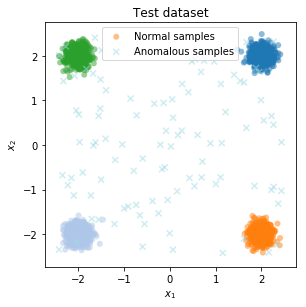

In [117]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

#### Z Test dataset

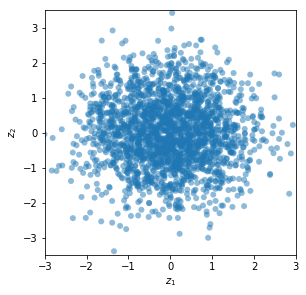

In [118]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

### Testing

In [119]:
feed_dict = {x: X_np_data_test, z:Z_np_data_test}
imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)
score_dz = sess.run(mahalanobis_dis_z, feed_dict=feed_dict)
score_dxx = sess.run(x_sigmoid_real + x_sigmoid_fake, feed_dict=feed_dict)

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims=False)
print(score)
def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)

[1.3457366 1.383152  1.8212433 ... 0.7033718 0.5848236 2.8382854]


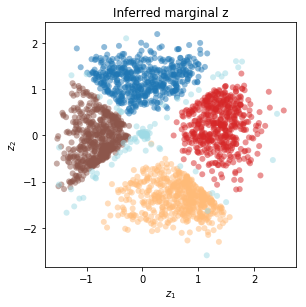

In [120]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

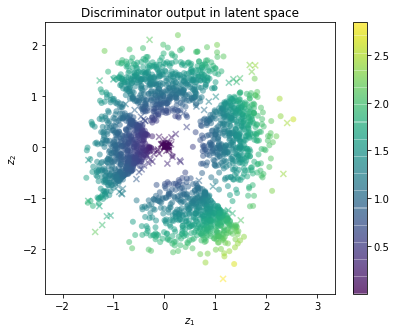

In [121]:
import matplotlib as mpl
## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

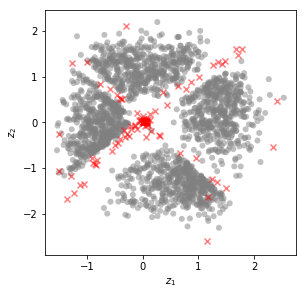

In [137]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

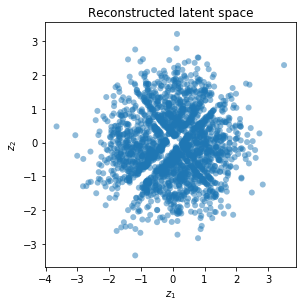

In [138]:
##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

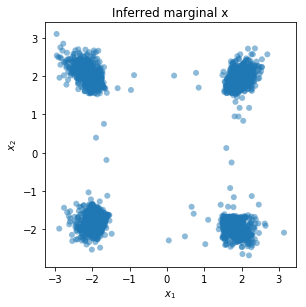

In [139]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

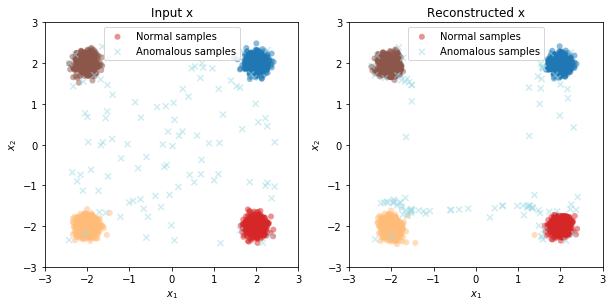

In [140]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

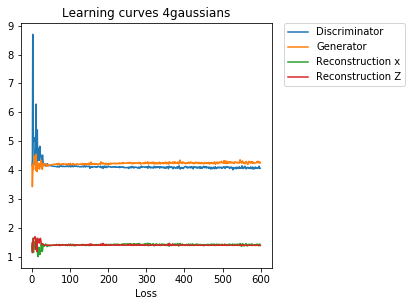

In [141]:
## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()